In [1]:
# 导入必要的库
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random
from torchvision import transforms, datasets
from torch.nn import init
import warnings
import cv2
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from torchdiffeq import odeint

warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 1.参数设置

In [ ]:
batch_size = 128
epochs_1rf = 70
epochs_2rf = 50
lr_1rf = 2e-4
lr_2rf = 1e-5  
beta1 = 0.5
save_every = 10
data_root = './data'
base_channels = 64
input_nc = 1
output_nc = 1
img_size = 28
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')
    print(f"GPU设备: {torch.cuda.get_device_name()}")
num_samples = 1000  # 用于计算IS和FID的样本数量
sampling_steps_1rf = 50  # 1-Rectified Flow采样步数
sampling_steps_2rf = 5   # 2-Rectified Flow采样步数

使用设备: cuda
GPU设备: NVIDIA GeForce RTX 4060 Laptop GPU


**参数说明**

超参数与数据/模型设置
| 参数名 | 默认值 | 含义 | 备注/建议 |
|---|---:|---|---|
| batch_size | 128 | 训练/评估批大小 | 受显存影响 |
| epochs_1rf | 70 | 1-Rectified Flow 训练轮数 | 可按收敛情况调整 |
| epochs_2rf | 50 | 2-Rectified Flow 训练轮数 | 可按收敛情况调整 |
| lr_1rf | 2e-4 | 1-RF 学习率 | AdamW |
| lr_2rf | 1e-5 | 2-RF 学习率 | AdamW |
| beta1 | 0.5 | 优化器 β1 | 代码未实际使用该变量 |
| save_every | 10 | 模型保存间隔（epoch） | 最后一轮也会保存 |
| data_root | ./data | MNIST 数据根目录 | 不存在会自动下载 |
| base_channels | 64 | MiniUNet 基础通道数 | 控制模型容量 |
| input_nc | 1 | 输入通道数 | MNIST 灰度图 |
| output_nc | 1 | 输出通道数 | 生成单通道 |
| img_size | 28 | 图像尺寸 | MNIST 固定为 28×

设备与加速设置
| 参数/开关 | 值 | 含义 | 备注 |
|---|---|---|---|
| device | cuda 或 cpu | 训练/推理设备选择 | 自动检测 CUDA |
| torch.backends.cuda.matmul.allow_tf32 | True | 允许 TF32 matmul | Ampere+ GPU 加速 |
| torch.backends.cudnn.allow_tf32 | True | 允许 TF32 cuDNN | 训练更快，精度轻微变化 |
| torch.set_float32_matmul_precision | 'high' | 控制 fp32 matmul 精度/性能 | PyTorch 2.x 选项 |

推理与评估参数
| 参数名 | 默认值 | 含义 | 备注 |
|---|---:|---|---|
| num_samples | 1000 | 计算 IS/FID 时的样本数 | 越大越稳定，耗时更久 |
| sampling_steps_1rf | 50 | 1-RF 欧拉法采样步数 | 与生成质量/速度权衡 |
| sampling_steps_2rf | 5 | 2-RF 欧拉法采样步数 | 步数少，生成更快 |

## 2.RectifiedFlow类与MiniUnet类

In [3]:
# 定义RectifiedFlow类
class RectifiedFlow:
    """Rectified Flow实现"""
    
    def vector_field(self, t, x):
        """向量场函数，用于torchdiffeq
        
        Args:
            t: 时间标量
            x: 当前状态，维度为 [B, C, H, W]
        
        Returns:
            向量场，维度为 [B, C, H, W]
        """
        # 将t扩展到与x相同的批次维度
        t_batch = t.expand(x.size(0))
        return self.model(x, t_batch)

    def create_flow(self, x_1, t, x_0=None):
        """使用x_t = t * x_1 + (1 - t) * x_0公式构建x_0到x_1的流
        
        Args:
            x_1: 原始图像，维度为 [B, C, H, W]
            t: 一个标量，表示时间，时间范围为 [0, 1]，维度为 [B]
            x_0: 噪声图像，维度为 [B, C, H, W]，默认值为None
            
        Returns:
            x_t: 在时间t的图像，维度为 [B, C, H, W]
            x_0: 噪声图像，维度为 [B, C, H, W]
        """
        # 需要一个x0，x0服从高斯噪声
        if x_0 is None:
            x_0 = torch.randn_like(x_1)

        t = t[:, None, None, None]  # [B, 1, 1, 1]

        # 获得xt的值
        x_t = t * x_1 + (1 - t) * x_0

        return x_t, x_0

    def mse_loss(self, v, x_1, x_0):
        """计算RectifiedFlow的损失函数
        L = MSE(x_1 - x_0 - v(t))  匀速直线运动

        Args:
            v: 速度，维度为 [B, C, H, W]
            x_1: 原始图像，维度为 [B, C, H, W]
            x_0: 噪声图像，维度为 [B, C, H, W]
        """
        loss = F.mse_loss(x_1 - x_0, v)
        return loss
    
    def set_model(self, model):
        """设置模型引用，用于向量场计算
        
        Args:
            model: 训练好的模型
        """
        self.model = model

In [4]:
# 定义MiniUnet模型组件
class DownLayer(nn.Module):
    """MiniUnet的下采样层 Resnet"""
    
    def __init__(self, in_channels, out_channels, time_emb_dim=16, downsample=False):
        super(DownLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.act = nn.ReLU()

        # 线性层，用于时间编码换通道 [B, dim] -> [B, in_channels]
        self.fc = nn.Linear(time_emb_dim, in_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

        # 降采样
        self.downsample = downsample
        if downsample:
            self.pool = nn.MaxPool2d(2)

        self.in_channels = in_channels

    def forward(self, x, temb):
        # x: [B, C, H, W]
        res = x
        x += self.fc(temb)[:, :, None, None]  # [B, in_channels, 1, 1]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        if self.shortcut is not None:
            res = self.shortcut(res)

        x = x + res

        if self.downsample:
            x = self.pool(x)

        return x

class UpLayer(nn.Module):
    """MiniUnet的上采样层"""
    
    def __init__(self, in_channels, out_channels, time_emb_dim=16, upsample=False):
        super(UpLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.act = nn.ReLU()

        # 线性层，用于时间编码换通道
        self.fc = nn.Linear(time_emb_dim, in_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

        self.upsample = upsample
        if upsample:
            self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x, temb):
        # 上采样
        if self.upsample:
            x = self.upsample(x)
        res = x

        x += self.fc(temb)[:, :, None, None]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        if self.shortcut is not None:
            res = self.shortcut(res)
        x = x + res

        return x

class MiddleLayer(nn.Module):
    """MiniUnet的中间层"""
    
    def __init__(self, in_channels, out_channels, time_emb_dim=16):
        super(MiddleLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.act = nn.ReLU()

        # 线性层，用于时间编码换通道
        self.fc = nn.Linear(time_emb_dim, in_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x, temb):
        res = x

        x += self.fc(temb)[:, :, None, None]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        if self.shortcut is not None:
            x = self.shortcut(x)
        x = x + res

        return x

# 定义MiniUnet模型
class MiniUnet(nn.Module):
    """采用MiniUnet，对MNIST数据做生成
        两个下采样block 一个中间block 两个上采样block
    """
    
    def __init__(self, base_channels=16, time_emb_dim=None):
        super(MiniUnet, self).__init__()

        if time_emb_dim is None:
            self.time_emb_dim = base_channels

        self.base_channels = base_channels

        self.conv_in = nn.Conv2d(1, base_channels, kernel_size=3, padding=1)

        # 多个Layer构成block
        self.down1 = nn.ModuleList([
            DownLayer(base_channels, base_channels * 2, time_emb_dim=self.time_emb_dim, downsample=False),
            DownLayer(base_channels * 2, base_channels * 2, time_emb_dim=self.time_emb_dim)
        ])
        self.maxpool1 = nn.MaxPool2d(2)

        self.down2 = nn.ModuleList([
            DownLayer(base_channels * 2, base_channels * 4, time_emb_dim=self.time_emb_dim, downsample=False),
            DownLayer(base_channels * 4, base_channels * 4, time_emb_dim=self.time_emb_dim)
        ])
        self.maxpool2 = nn.MaxPool2d(2)

        self.middle = MiddleLayer(base_channels * 4, base_channels * 4, time_emb_dim=self.time_emb_dim)

        self.upsample1 = nn.Upsample(scale_factor=2)
        self.up1 = nn.ModuleList([
            UpLayer(base_channels * 8, base_channels * 2, time_emb_dim=self.time_emb_dim, upsample=False),
            UpLayer(base_channels * 2, base_channels * 2, time_emb_dim=self.time_emb_dim)
        ])
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.up2 = nn.ModuleList([
            UpLayer(base_channels * 4, base_channels, time_emb_dim=self.time_emb_dim, upsample=False),
            UpLayer(base_channels, base_channels, time_emb_dim=self.time_emb_dim)
        ])

        self.conv_out = nn.Conv2d(base_channels, 1, kernel_size=1, padding=0)

    def time_emb(self, t, dim):
        """对时间进行正弦函数的编码，单一维度
        
        Args:
            t (float): 时间，维度为[B]
            dim (int): 编码的维度

        Returns:
            torch.Tensor: 编码后的时间，维度为[B, dim]
        """
        # 生成正弦编码
        # 把t映射到[0, 1000]
        t = t * 1000
        # 10000^k k=torch.linspace……
        freqs = torch.pow(10000, torch.linspace(0, 1, dim // 2)).to(t.device)
        sin_emb = torch.sin(t[:, None] / freqs)
        cos_emb = torch.cos(t[:, None] / freqs)

        return torch.cat([sin_emb, cos_emb], dim=-1)

    

    def forward(self, x, t):
        """前向传播函数

        Args:
            x (torch.Tensor): 输入数据，维度为[B, C, H, W]
            t (torch.Tensor): 时间，维度为[B]
        """
        # x:(B, C, H, W)
        # 时间编码加上
        x = self.conv_in(x)
        # 时间编码
        temb = self.time_emb(t, self.base_channels)
        
        # 下采样
        for layer in self.down1:
            x = layer(x, temb)
        x1 = x
        x = self.maxpool1(x)
        for layer in self.down2:
            x = layer(x, temb)
        x2 = x
        x = self.maxpool2(x)

        # 中间层
        x = self.middle(x, temb)

        # 上采样
        x = torch.cat([self.upsample1(x), x2], dim=1)
        for layer in self.up1:
            x = layer(x, temb)
        x = torch.cat([self.upsample2(x), x1], dim=1)
        for layer in self.up2:
            x = layer(x, temb)

        x = self.conv_out(x)
        return x

In [ ]:
# 定义ReflowDataset类
class ReflowDataset(Dataset):
    """ReflowDataset
    用于训练Reflow模型的数据集（内存版本）
    
    Args:
        img_tensors (list): 图像张量列表
        noise_tensors (list): 噪声张量列表
        transform (optional): 图像transform. Defaults to None.
    """
    
    def __init__(self, img_tensors, noise_tensors, transform=None):
        self.img_tensors = img_tensors
        self.noise_tensors = noise_tensors
        self.transform = transform

    def __len__(self):
        return len(self.img_tensors)

    def __getitem__(self, idx):
        img = self.img_tensors[idx]
        noise = self.noise_tensors[idx]

        if self.transform:
            img = self.transform(img)

        return {'img': img, 'noise': noise, 'label': 0}

## 3.数据集加载与模型初始化

In [6]:
# 加载MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor()
])

print(f"正在加载MNIST数据集从 {data_root}...")
mnist_dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(f"MNIST数据集加载成功，数据集大小: {len(mnist_dataset)}")

正在加载MNIST数据集从 ./data...
MNIST数据集加载成功，数据集大小: 60000


In [7]:
# 初始化1-Rectified Flow模型
print("初始化1-Rectified Flow模型...")
model_1rf = MiniUnet(base_channels=base_channels).to(device)
rf = RectifiedFlow()

# 定义优化器和损失函数
optimizer_1rf = optim.AdamW(model_1rf.parameters(), lr=lr_1rf, weight_decay=0.1)
scheduler_1rf = optim.lr_scheduler.StepLR(optimizer_1rf, step_size=30, gamma=0.1)

# 训练历史记录
losses_history_1rf = []

# 创建保存目录
os.makedirs('./checkpoints/1rf', exist_ok=True)
os.makedirs('./results/1rf', exist_ok=True)
os.makedirs('./data', exist_ok=True)

print(f"1-Rectified Flow模型参数数量: {sum(p.numel() for p in model_1rf.parameters())}")

初始化1-Rectified Flow模型...
1-Rectified Flow模型参数数量: 5299457


## 4.训练1-Rectified Flow模型

In [8]:
# 训练1-Rectified Flow模型
print(f"开始训练1-Rectified Flow，总轮数: {epochs_1rf}")

for epoch in range(1,epochs_1rf+1):
    epoch_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(mnist_dataloader, desc=f'Epoch {epoch}/{epochs_1rf}')
    for i, (imgs, labels) in enumerate(pbar):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # 均匀采样[0, 1]的时间t
        t = torch.rand(imgs.size(0)).to(device)
        
        # 生成flow
        x_t, x_0 = rf.create_flow(imgs, t)
        
        optimizer_1rf.zero_grad()
        
        # 预测速度场
        v_pred = model_1rf(x=x_t, t=t)
        
        # 计算损失
        loss = rf.mse_loss(v_pred, imgs, x_0)
        
        loss.backward()
        optimizer_1rf.step()
        
        # 记录损失
        epoch_loss += loss.item()
        num_batches += 1
        
        # 更新进度条
        pbar.set_postfix({'loss': loss.item()})
    
    # 计算平均损失
    avg_loss = epoch_loss / num_batches
    losses_history_1rf.append(avg_loss)
    
    # 更新学习率
    scheduler_1rf.step()
    
    # 打印epoch信息
    print(f"Epoch {epoch}/{epochs_1rf} - Loss: {avg_loss:.4f}")
    
    # 保存模型
    if epoch % save_every == 0 or epoch == epochs_1rf:
        torch.save({
            'model': model_1rf.state_dict(),
            'optimizer': optimizer_1rf.state_dict(),
            'epoch': epoch,
            'loss': avg_loss,
            'loss_history': losses_history_1rf
        }, f'./checkpoints/1rf/miniunet_{epoch}.pth')
        print(f"模型已保存到 ./checkpoints/1rf/miniunet_{epoch}.pth")

print("1-Rectified Flow训练完成！")

开始训练1-Rectified Flow，总轮数: 70


Epoch 1/70: 100%|██████████| 469/469 [01:19<00:00,  5.93it/s, loss=0.14] 


Epoch 1/70 - Loss: 0.1811


Epoch 2/70: 100%|██████████| 469/469 [01:10<00:00,  6.64it/s, loss=0.114]  


Epoch 2/70 - Loss: 0.1190


Epoch 3/70: 100%|██████████| 469/469 [01:02<00:00,  7.44it/s, loss=0.0966]


Epoch 3/70 - Loss: 0.1088


Epoch 4/70: 100%|██████████| 469/469 [01:17<00:00,  6.08it/s, loss=0.102] 


Epoch 4/70 - Loss: 0.1037


Epoch 5/70: 100%|██████████| 469/469 [01:09<00:00,  6.72it/s, loss=0.0982] 


Epoch 5/70 - Loss: 0.1005


Epoch 6/70: 100%|██████████| 469/469 [01:03<00:00,  7.43it/s, loss=0.109] 


Epoch 6/70 - Loss: 0.0981


Epoch 7/70: 100%|██████████| 469/469 [01:17<00:00,  6.08it/s, loss=0.0902]


Epoch 7/70 - Loss: 0.0964


Epoch 8/70: 100%|██████████| 469/469 [01:03<00:00,  7.44it/s, loss=0.0914]


Epoch 8/70 - Loss: 0.0951


Epoch 9/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0968]


Epoch 9/70 - Loss: 0.0941


Epoch 10/70: 100%|██████████| 469/469 [01:10<00:00,  6.68it/s, loss=0.0875]


Epoch 10/70 - Loss: 0.0936
模型已保存到 ./checkpoints/1rf/miniunet_10.pth


Epoch 11/70: 100%|██████████| 469/469 [01:17<00:00,  6.09it/s, loss=0.0966]


Epoch 11/70 - Loss: 0.0923


Epoch 12/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0908]


Epoch 12/70 - Loss: 0.0917


Epoch 13/70: 100%|██████████| 469/469 [01:10<00:00,  6.66it/s, loss=0.0897]


Epoch 13/70 - Loss: 0.0916


Epoch 14/70: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s, loss=0.0991]


Epoch 14/70 - Loss: 0.0912


Epoch 15/70: 100%|██████████| 469/469 [01:09<00:00,  6.71it/s, loss=0.0907]


Epoch 15/70 - Loss: 0.0906


Epoch 16/70: 100%|██████████| 469/469 [01:10<00:00,  6.68it/s, loss=0.0897]


Epoch 16/70 - Loss: 0.0903


Epoch 17/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0891]


Epoch 17/70 - Loss: 0.0896


Epoch 18/70: 100%|██████████| 469/469 [01:17<00:00,  6.09it/s, loss=0.0923]


Epoch 18/70 - Loss: 0.0893


Epoch 19/70: 100%|██████████| 469/469 [01:03<00:00,  7.43it/s, loss=0.0882]


Epoch 19/70 - Loss: 0.0892


Epoch 20/70: 100%|██████████| 469/469 [01:10<00:00,  6.68it/s, loss=0.0916]


Epoch 20/70 - Loss: 0.0889
模型已保存到 ./checkpoints/1rf/miniunet_20.pth


Epoch 21/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0937]


Epoch 21/70 - Loss: 0.0885


Epoch 22/70: 100%|██████████| 469/469 [01:16<00:00,  6.10it/s, loss=0.0857]


Epoch 22/70 - Loss: 0.0885


Epoch 23/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0979]


Epoch 23/70 - Loss: 0.0880


Epoch 24/70: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s, loss=0.0841]


Epoch 24/70 - Loss: 0.0876


Epoch 25/70: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s, loss=0.0888]


Epoch 25/70 - Loss: 0.0878


Epoch 26/70: 100%|██████████| 469/469 [01:17<00:00,  6.09it/s, loss=0.081] 


Epoch 26/70 - Loss: 0.0873


Epoch 27/70: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s, loss=0.0847] 


Epoch 27/70 - Loss: 0.0873


Epoch 28/70: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s, loss=0.0932]


Epoch 28/70 - Loss: 0.0870


Epoch 29/70: 100%|██████████| 469/469 [01:09<00:00,  6.72it/s, loss=0.0923]


Epoch 29/70 - Loss: 0.0870


Epoch 30/70: 100%|██████████| 469/469 [01:17<00:00,  6.07it/s, loss=0.0865]


Epoch 30/70 - Loss: 0.0867
模型已保存到 ./checkpoints/1rf/miniunet_30.pth


Epoch 31/70: 100%|██████████| 469/469 [01:02<00:00,  7.46it/s, loss=0.0885]  


Epoch 31/70 - Loss: 0.0846


Epoch 32/70: 100%|██████████| 469/469 [01:09<00:00,  6.72it/s, loss=0.0836]


Epoch 32/70 - Loss: 0.0840


Epoch 33/70: 100%|██████████| 469/469 [01:09<00:00,  6.70it/s, loss=0.0833]


Epoch 33/70 - Loss: 0.0841


Epoch 34/70: 100%|██████████| 469/469 [01:17<00:00,  6.09it/s, loss=0.0782]


Epoch 34/70 - Loss: 0.0839


Epoch 35/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0798]  


Epoch 35/70 - Loss: 0.0837


Epoch 36/70: 100%|██████████| 469/469 [01:09<00:00,  6.70it/s, loss=0.0958]


Epoch 36/70 - Loss: 0.0838


Epoch 37/70: 100%|██████████| 469/469 [01:10<00:00,  6.68it/s, loss=0.0859]


Epoch 37/70 - Loss: 0.0836


Epoch 38/70: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s, loss=0.0832]


Epoch 38/70 - Loss: 0.0836


Epoch 39/70: 100%|██████████| 469/469 [01:09<00:00,  6.71it/s, loss=0.0788]


Epoch 39/70 - Loss: 0.0836


Epoch 40/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0826]


Epoch 40/70 - Loss: 0.0833
模型已保存到 ./checkpoints/1rf/miniunet_40.pth


Epoch 41/70: 100%|██████████| 469/469 [01:09<00:00,  6.70it/s, loss=0.0819]


Epoch 41/70 - Loss: 0.0833


Epoch 42/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0953]


Epoch 42/70 - Loss: 0.0831


Epoch 43/70: 100%|██████████| 469/469 [01:09<00:00,  6.71it/s, loss=0.0831]


Epoch 43/70 - Loss: 0.0834


Epoch 44/70: 100%|██████████| 469/469 [01:09<00:00,  6.70it/s, loss=0.0779]


Epoch 44/70 - Loss: 0.0832


Epoch 45/70: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s, loss=0.08]  


Epoch 45/70 - Loss: 0.0833


Epoch 46/70: 100%|██████████| 469/469 [01:09<00:00,  6.72it/s, loss=0.0812]


Epoch 46/70 - Loss: 0.0832


Epoch 47/70: 100%|██████████| 469/469 [01:17<00:00,  6.07it/s, loss=0.09]  


Epoch 47/70 - Loss: 0.0832


Epoch 48/70: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s, loss=0.0887]


Epoch 48/70 - Loss: 0.0831


Epoch 49/70: 100%|██████████| 469/469 [01:17<00:00,  6.09it/s, loss=0.0801]


Epoch 49/70 - Loss: 0.0827


Epoch 50/70: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s, loss=0.0816]


Epoch 50/70 - Loss: 0.0831
模型已保存到 ./checkpoints/1rf/miniunet_50.pth


Epoch 51/70: 100%|██████████| 469/469 [01:09<00:00,  6.71it/s, loss=0.0793]


Epoch 51/70 - Loss: 0.0829


Epoch 52/70: 100%|██████████| 469/469 [01:17<00:00,  6.08it/s, loss=0.0838]


Epoch 52/70 - Loss: 0.0831


Epoch 53/70: 100%|██████████| 469/469 [01:02<00:00,  7.48it/s, loss=0.0845]


Epoch 53/70 - Loss: 0.0830


Epoch 54/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0937]


Epoch 54/70 - Loss: 0.0829


Epoch 55/70: 100%|██████████| 469/469 [01:09<00:00,  6.70it/s, loss=0.0829]


Epoch 55/70 - Loss: 0.0830


Epoch 56/70: 100%|██████████| 469/469 [01:17<00:00,  6.09it/s, loss=0.0867]


Epoch 56/70 - Loss: 0.0830


Epoch 57/70: 100%|██████████| 469/469 [01:03<00:00,  7.44it/s, loss=0.0846]


Epoch 57/70 - Loss: 0.0828


Epoch 58/70: 100%|██████████| 469/469 [01:09<00:00,  6.70it/s, loss=0.0824]


Epoch 58/70 - Loss: 0.0829


Epoch 59/70: 100%|██████████| 469/469 [01:17<00:00,  6.07it/s, loss=0.0819]


Epoch 59/70 - Loss: 0.0830


Epoch 60/70: 100%|██████████| 469/469 [01:02<00:00,  7.47it/s, loss=0.0821]


Epoch 60/70 - Loss: 0.0827
模型已保存到 ./checkpoints/1rf/miniunet_60.pth


Epoch 61/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0795]


Epoch 61/70 - Loss: 0.0824


Epoch 62/70: 100%|██████████| 469/469 [01:09<00:00,  6.70it/s, loss=0.0867]


Epoch 62/70 - Loss: 0.0828


Epoch 63/70: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s, loss=0.0843]


Epoch 63/70 - Loss: 0.0826


Epoch 64/70: 100%|██████████| 469/469 [01:17<00:00,  6.08it/s, loss=0.0826]


Epoch 64/70 - Loss: 0.0825


Epoch 65/70: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s, loss=0.0806]


Epoch 65/70 - Loss: 0.0824


Epoch 66/70: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s, loss=0.0952]


Epoch 66/70 - Loss: 0.0824


Epoch 67/70: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s, loss=0.0841]


Epoch 67/70 - Loss: 0.0823


Epoch 68/70: 100%|██████████| 469/469 [01:17<00:00,  6.07it/s, loss=0.0819]


Epoch 68/70 - Loss: 0.0824


Epoch 69/70: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s, loss=0.08]    


Epoch 69/70 - Loss: 0.0823


Epoch 70/70: 100%|██████████| 469/469 [01:02<00:00,  7.47it/s, loss=0.0863]

Epoch 70/70 - Loss: 0.0825
模型已保存到 ./checkpoints/1rf/miniunet_70.pth
1-Rectified Flow训练完成！


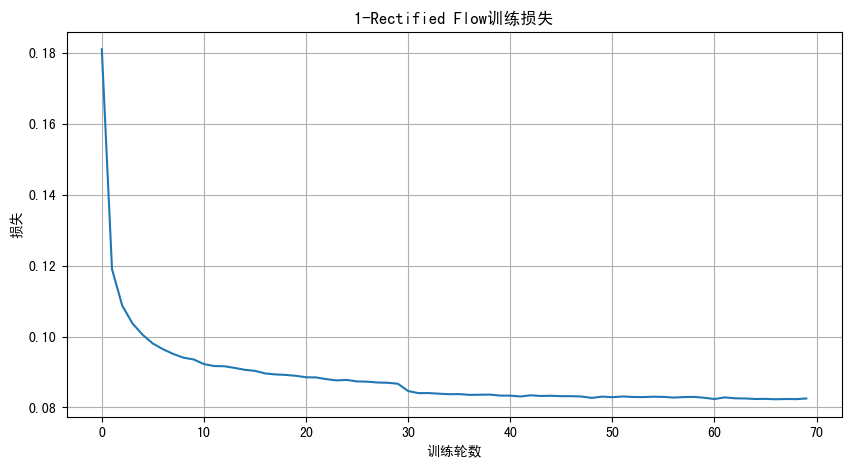

In [9]:
# 绘制1-Rectified Flow损失曲线
plt.figure(figsize=(10, 5))
plt.plot(losses_history_1rf)
plt.xlabel('训练轮数')
plt.ylabel('损失')
plt.title('1-Rectified Flow训练损失')
plt.grid(True)
plt.savefig('./results/1rf/loss_curve.png', dpi=600)
plt.show()

## 5.使用1-Rectified Flow推理测试同时为2-Rectified Flow准备训练数据

In [10]:
# 1-Rectified Flow推理函数
def infer_1rf(model, rf, num_samples=10, steps=50, save_path='./results/1rf'):
    """1-Rectified Flow推理函数
    
    Args:
        model: 训练好的模型
        rf: RectifiedFlow实例
        num_samples: 生成样本数量
        steps: 采样步数
        save_path: 保存路径
    """
    model.eval()
    os.makedirs(save_path, exist_ok=True)
    
    generated_images = []
    
    # 设置模型引用到RectifiedFlow
    rf.set_model(model)
    
    with torch.no_grad():
        pbar = tqdm(range(num_samples), desc=f'生成1-RF样本 (步数: {steps})')
        for i in pbar:
            # 初始噪声
            x_0 = torch.randn(1, 1, img_size, img_size).to(device)
            
            # 使用torchdiffeq进行ODE求解
            t_span = torch.linspace(0, 1, steps).to(device)
            trajectory = odeint(rf.vector_field, x_0, t_span, method='euler')
            x_t = trajectory[-1]  # 取最后一个时间点的结果
            
            # 保存生成的图像
            raw = x_t[0, 0].cpu().numpy()  # (28,28)
            # 归一化到 0-255（防止值域异常）
            norm = (raw - raw.min()) / (raw.max() - raw.min() + 1e-8)
            img_uint8 = (norm * 255).astype(np.uint8)
            cv2.imwrite(os.path.join(save_path, f'gen_{i}.png'), img_uint8)
            generated_images.append(x_t[0].cpu())
            
            # 更新进度条
            pbar.set_postfix({'样本': f'{i+1}/{num_samples}'})
    
    return torch.stack(generated_images)

In [11]:
# 运行1-Rectified Flow推理并生成图像
print("运行1-Rectified Flow推理...")
generated_images_1rf = infer_1rf(model_1rf, rf, num_samples=20, steps=sampling_steps_1rf)
print(f"生成了 {len(generated_images_1rf)} 张图像")

运行1-Rectified Flow推理...


生成1-RF样本 (步数: 50): 100%|██████████| 20/20 [00:04<00:00,  4.37it/s, 样本=20/20]

生成了 20 张图像


In [12]:
# 创建Reflow数据集（用于2-Rectified Flow训练，内存版本）
def create_reflow_dataset(model, rf, num_samples=5000, steps=50):
    """创建Reflow数据集（内存版本）
    
    Args:
        model: 训练好的1-Rectified Flow模型
        rf: RectifiedFlow实例
        num_samples: 生成样本数量
        steps: 采样步数
    
    Returns:
        img_tensors: 生成的图像张量列表
        noise_tensors: 对应的噪声张量列表
    """
    model.eval()
    
    print(f"正在生成 {num_samples} 个样本用于2-Rectified Flow训练...")
    
    img_tensors = []
    noise_tensors = []
    
    # 设置模型引用到RectifiedFlow
    rf.set_model(model)
    
    with torch.no_grad():
        for i in tqdm(range(num_samples)):
            # 初始噪声
            x_0 = torch.randn(1, 1, img_size, img_size).to(device)
            
            # 使用torchdiffeq进行ODE求解
            t_span = torch.linspace(0, 1, steps).to(device)
            trajectory = odeint(rf.vector_field, x_0, t_span, method='euler')
            x_1 = trajectory[-1]  # 取最后一个时间点的结果
            
            # 收集图像和噪声
            img_tensors.append(x_1[0].cpu())
            noise_tensors.append(x_0[0].cpu())
    
    print(f"Reflow数据集创建完成，共 {len(img_tensors)} 个样本")
    return img_tensors, noise_tensors

# 创建Reflow数据集
img_tensors, noise_tensors = create_reflow_dataset(model_1rf, rf, num_samples=10000, steps=sampling_steps_1rf)

正在生成 10000 个样本用于2-Rectified Flow训练...


100%|██████████| 10000/10000 [31:58<00:00,  5.21it/s]

Reflow数据集创建完成，共 10000 个样本


## 6.初始化2-recctified flow模型并训练

In [13]:
# 初始化2-Rectified Flow模型
print("初始化2-Rectified Flow模型...")
model_2rf = MiniUnet(base_channels=base_channels).to(device)

# 加载1-Rectified Flow预训练权重
checkpoint_1rf = torch.load(f'./checkpoints/1rf/miniunet_{epochs_1rf}.pth')
model_2rf.load_state_dict(checkpoint_1rf['model'])
print("已加载1-Rectified Flow预训练权重")

# 定义优化器和损失函数
optimizer_2rf = optim.AdamW(model_2rf.parameters(), lr=lr_2rf, weight_decay=0.1)
scheduler_2rf = optim.lr_scheduler.StepLR(optimizer_2rf, step_size=10, gamma=0.1)

# 训练历史记录
losses_history_2rf = []

# 创建保存目录
os.makedirs('./checkpoints/2rf', exist_ok=True)
os.makedirs('./results/2rf', exist_ok=True)

初始化2-Rectified Flow模型...
已加载1-Rectified Flow预训练权重


In [14]:
# 创建Reflow数据集加载器
reflow_transform = transforms.Lambda(lambda x: x)  # 已经是tensor，不需要变换
reflow_dataset = ReflowDataset(img_tensors=img_tensors,
                               noise_tensors=noise_tensors,
                               transform=reflow_transform)
reflow_dataloader = DataLoader(reflow_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(f"Reflow数据集创建成功，数据集大小: {len(reflow_dataset)}")

Reflow数据集创建成功，数据集大小: 10000


In [15]:
# 训练2-Rectified Flow模型
print(f"开始训练2-Rectified Flow，总轮数: {epochs_2rf}")

for epoch in range(1, epochs_2rf + 1):
    epoch_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(reflow_dataloader, desc=f'Epoch {epoch}/{epochs_2rf}')
    for i, data in enumerate(pbar):
        x_1 = data['img'].to(device)
        x_0 = data['noise'].to(device)
        
        # 均匀采样[0, 1]的时间t
        t = torch.rand(x_1.size(0)).to(device)
        
        # 生成flow
        x_t, _ = rf.create_flow(x_1, t, x_0)
        
        optimizer_2rf.zero_grad()
        
        # 预测速度场
        v_pred = model_2rf(x=x_t, t=t)
        
        # 计算损失
        loss = rf.mse_loss(v_pred, x_1, x_0)
        
        loss.backward()
        optimizer_2rf.step()
        
        # 记录损失
        epoch_loss += loss.item()
        num_batches += 1
        
        # 更新进度条
        pbar.set_postfix({'loss': loss.item()})
    
    # 计算平均损失
    avg_loss = epoch_loss / num_batches
    losses_history_2rf.append(avg_loss)
    
    # 更新学习率
    scheduler_2rf.step()
    
    # 打印epoch信息
    print(f"Epoch {epoch}/{epochs_2rf} - Loss: {avg_loss:.4f}")
    
    # 保存模型
    if (epoch) % save_every == 0 or epoch == epochs_2rf:
        torch.save({
            'model': model_2rf.state_dict(),
            'optimizer': optimizer_2rf.state_dict(),
            'epoch': epoch,
            'loss': avg_loss,
            'losses_history': losses_history_2rf
        }, f'./checkpoints/2rf/miniunet_{epoch}.pth')
        print(f"模型已保存到 ./checkpoints/2rf/miniunet_{epoch}.pth")

print("2-Rectified Flow训练完成！")

开始训练2-Rectified Flow，总轮数: 50


Epoch 1/50: 100%|██████████| 79/79 [00:04<00:00, 16.10it/s, loss=0.0119]


Epoch 1/50 - Loss: 0.0192


Epoch 2/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.0119] 


Epoch 2/50 - Loss: 0.0102


Epoch 3/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.0138] 


Epoch 3/50 - Loss: 0.0081


Epoch 4/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.00805]


Epoch 4/50 - Loss: 0.0074


Epoch 5/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.00659]


Epoch 5/50 - Loss: 0.0064


Epoch 6/50: 100%|██████████| 79/79 [00:18<00:00,  4.19it/s, loss=0.0066] 


Epoch 6/50 - Loss: 0.0061


Epoch 7/50: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s, loss=0.00625]


Epoch 7/50 - Loss: 0.0060


Epoch 8/50: 100%|██████████| 79/79 [00:04<00:00, 16.78it/s, loss=0.00631]   


Epoch 8/50 - Loss: 0.0058


Epoch 9/50: 100%|██████████| 79/79 [00:18<00:00,  4.20it/s, loss=0.00463]


Epoch 9/50 - Loss: 0.0052


Epoch 10/50: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.00763]


Epoch 10/50 - Loss: 0.0051
模型已保存到 ./checkpoints/2rf/miniunet_10.pth


Epoch 11/50: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.0114] 


Epoch 11/50 - Loss: 0.0052


Epoch 12/50: 100%|██████████| 79/79 [00:04<00:00, 16.62it/s, loss=0.00825]


Epoch 12/50 - Loss: 0.0052


Epoch 13/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.0051] 


Epoch 13/50 - Loss: 0.0052


Epoch 14/50: 100%|██████████| 79/79 [00:18<00:00,  4.19it/s, loss=0.00462]


Epoch 14/50 - Loss: 0.0052


Epoch 15/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.00518]   


Epoch 15/50 - Loss: 0.0049


Epoch 16/50: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s, loss=0.00485]


Epoch 16/50 - Loss: 0.0050


Epoch 17/50: 100%|██████████| 79/79 [00:04<00:00, 17.05it/s, loss=0.00734]   


Epoch 17/50 - Loss: 0.0051


Epoch 18/50: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.00537]


Epoch 18/50 - Loss: 0.0049


Epoch 19/50: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.00694]


Epoch 19/50 - Loss: 0.0051


Epoch 20/50: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s, loss=0.00733]


Epoch 20/50 - Loss: 0.0051
模型已保存到 ./checkpoints/2rf/miniunet_20.pth


Epoch 21/50: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.00554]


Epoch 21/50 - Loss: 0.0049


Epoch 22/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.0115] 


Epoch 22/50 - Loss: 0.0055


Epoch 23/50: 100%|██████████| 79/79 [00:18<00:00,  4.18it/s, loss=0.00459]


Epoch 23/50 - Loss: 0.0051


Epoch 24/50: 100%|██████████| 79/79 [00:04<00:00, 16.77it/s, loss=0.00975]


Epoch 24/50 - Loss: 0.0053


Epoch 25/50: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.00435]


Epoch 25/50 - Loss: 0.0050


Epoch 26/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.00697]


Epoch 26/50 - Loss: 0.0050


Epoch 27/50: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s, loss=0.00637]


Epoch 27/50 - Loss: 0.0053


Epoch 28/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.00649]


Epoch 28/50 - Loss: 0.0049


Epoch 29/50: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.00758]


Epoch 29/50 - Loss: 0.0049


Epoch 30/50: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.0059] 


Epoch 30/50 - Loss: 0.0047
模型已保存到 ./checkpoints/2rf/miniunet_30.pth


Epoch 31/50: 100%|██████████| 79/79 [00:18<00:00,  4.19it/s, loss=0.00574]


Epoch 31/50 - Loss: 0.0049


Epoch 32/50: 100%|██████████| 79/79 [00:04<00:00, 16.81it/s, loss=0.0154]    


Epoch 32/50 - Loss: 0.0053


Epoch 33/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.00782]


Epoch 33/50 - Loss: 0.0051


Epoch 34/50: 100%|██████████| 79/79 [00:18<00:00,  4.19it/s, loss=0.00442]


Epoch 34/50 - Loss: 0.0050


Epoch 35/50: 100%|██████████| 79/79 [00:04<00:00, 16.79it/s, loss=0.00433]


Epoch 35/50 - Loss: 0.0048


Epoch 36/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.00653]


Epoch 36/50 - Loss: 0.0052


Epoch 37/50: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.00443]


Epoch 37/50 - Loss: 0.0051


Epoch 38/50: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.0056] 


Epoch 38/50 - Loss: 0.0048


Epoch 39/50: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.00921]


Epoch 39/50 - Loss: 0.0050


Epoch 40/50: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s, loss=0.00609]


Epoch 40/50 - Loss: 0.0048
模型已保存到 ./checkpoints/2rf/miniunet_40.pth


Epoch 41/50: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.00355]


Epoch 41/50 - Loss: 0.0047


Epoch 42/50: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.00673]


Epoch 42/50 - Loss: 0.0048


Epoch 43/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.00443]


Epoch 43/50 - Loss: 0.0049


Epoch 44/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.00563]


Epoch 44/50 - Loss: 0.0053


Epoch 45/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.0114] 


Epoch 45/50 - Loss: 0.0051


Epoch 46/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.0559] 


Epoch 46/50 - Loss: 0.0056


Epoch 47/50: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.00567]


Epoch 47/50 - Loss: 0.0050


Epoch 48/50: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.00632]


Epoch 48/50 - Loss: 0.0052


Epoch 49/50: 100%|██████████| 79/79 [00:18<00:00,  4.19it/s, loss=0.00455]


Epoch 49/50 - Loss: 0.0048


Epoch 50/50: 100%|██████████| 79/79 [00:04<00:00, 17.03it/s, loss=0.00758]


Epoch 50/50 - Loss: 0.0049
模型已保存到 ./checkpoints/2rf/miniunet_50.pth
2-Rectified Flow训练完成！


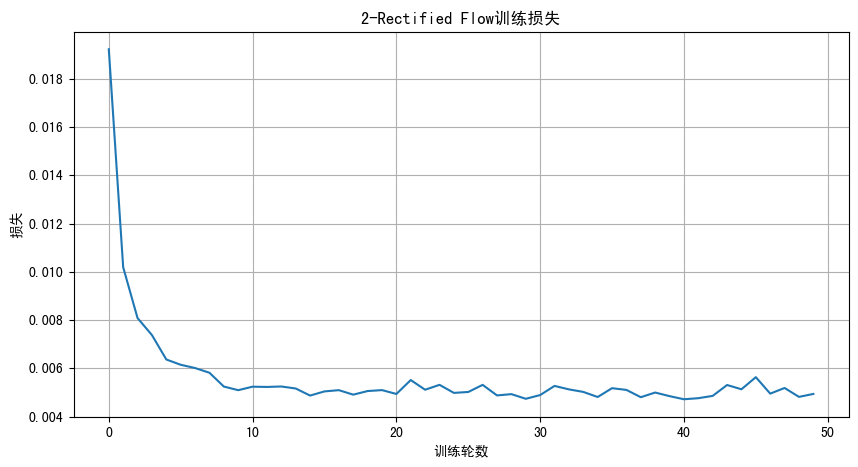

In [16]:
# 绘制2-Rectified Flow损失曲线
plt.figure(figsize=(10, 5))
plt.plot(losses_history_2rf)
plt.xlabel('训练轮数')
plt.ylabel('损失')
plt.title('2-Rectified Flow训练损失')
plt.grid(True)
plt.savefig('./results/2rf/loss_curve.png', dpi=600)
plt.show()

## 7.使用2-rectified flow推理测试

In [ ]:
# 2-Rectified Flow推理函数
def infer_2rf(model, rf, num_samples=10, steps=5, save_path='./results/2rf'):
    """2-Rectified Flow推理函数
    
    Args:
        model: 训练好的模型
        rf: RectifiedFlow实例
        num_samples: 生成样本数量
        steps: 采样步数
        save_path: 保存路径
    """
    model.eval()
    os.makedirs(save_path, exist_ok=True)
    
    generated_images = []
    
    # 设置模型引用到RectifiedFlow
    rf.set_model(model)
    
    with torch.no_grad():
        pbar = tqdm(range(num_samples), desc=f'生成2-RF样本 (步数: {steps})')
        for i in pbar:
            # 初始噪声
            x_0 = torch.randn(1, 1, img_size, img_size).to(device)
            
            # 使用torchdiffeq进行ODE求解
            t_span = torch.linspace(0, 1, steps).to(device)
            trajectory = odeint(rf.vector_field, x_0, t_span, method='euler')
            x_t = trajectory[-1]  # 取最后一个时间点的结果

            # 保存生成的图像
            raw = x_t[0, 0].cpu().numpy()  # (28,28)
            # 归一化到 0-255（防止值域异常）
            norm = (raw - raw.min()) / (raw.max() - raw.min() + 1e-8)
            img_uint8 = (norm * 255).astype(np.uint8)
            cv2.imwrite(os.path.join(save_path, f'gen_{i}.png'), img_uint8)
            generated_images.append(x_t[0].cpu())
            
            # 更新进度条
            pbar.set_postfix({'样本': f'{i+1}/{num_samples}'})
    
    return torch.stack(generated_images)

In [18]:
# 运行2-Rectified Flow推理并生成图像
print("运行2-Rectified Flow推理...")
generated_images_2rf = infer_2rf(model_2rf, rf, num_samples=20, steps=sampling_steps_2rf)
print(f"生成了 {len(generated_images_2rf)} 张图像")

运行2-Rectified Flow推理...


生成2-RF样本 (步数: 5): 100%|██████████| 20/20 [00:00<00:00, 59.01it/s, 样本=20/20]

生成了 20 张图像


## 8.计算两模型的IS和FID

In [19]:
# 计算IS和FID指标
def calculate_metrics(generated_images, real_images, device):
    """计算IS和FID指标
    
    Args:
        generated_images: 生成的图像张量，[N, C, H, W]
        real_images: 真实图像张量，[N, C, H, W]
        device: 计算设备
    
    Returns:
        is_mean, is_std: Inception Score的均值和标准差
        fid: Frechet Inception Distance
    """

    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)

    # 转换为3通道
    generated_3ch = generated_images.repeat(1, 3, 1, 1)
    real_3ch = real_images.repeat(1, 3, 1, 1)

    # 如果原始范围是任意实数，先压到[0,1]再乘255
    gen_min, gen_max = generated_3ch.min(), generated_3ch.max()
    if (gen_max - gen_min) > 1e-8:
        generated_3ch = (generated_3ch - gen_min) / (gen_max - gen_min)
    real_min, real_max = real_3ch.min(), real_3ch.max()
    if (real_max - real_min) > 1e-8:
        real_3ch = (real_3ch - real_min) / (real_max - real_min)

    # 转 uint8 后放到 device
    generated_3ch = (generated_3ch * 255).clamp(0, 255).to(torch.uint8).to(device)
    real_3ch = (real_3ch * 255).clamp(0, 255).to(torch.uint8).to(device)

    # IS
    inception.update(generated_3ch)
    is_mean, is_std = inception.compute()

    # FID
    fid.update(generated_3ch, real=False)
    fid.update(real_3ch, real=True)
    fid_score = fid.compute()

    return is_mean.item(), is_std.item(), fid_score.item()

In [20]:
# 加载真实MNIST图像用于计算指标
print("加载真实MNIST图像用于计算指标...")
transform_eval = transforms.ToTensor()
real_dataset = datasets.MNIST(root=data_root, train=False, download=True, transform=transform_eval)
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)
real_images = []
for imgs, _ in real_dataloader:
    real_images.append(imgs)
    if len(real_images) * batch_size >= num_samples:
        break
real_images = torch.cat(real_images, dim=0)[:num_samples]
print(f"加载了 {len(real_images)} 张真实图像")

加载真实MNIST图像用于计算指标...
加载了 1000 张真实图像


In [21]:
# 计算1-Rectified Flow的IS和FID指标
print("计算1-Rectified Flow的IS和FID指标...")
is_mean_1rf, is_std_1rf, fid_1rf = calculate_metrics(generated_images_1rf, real_images, device)
print(f"1-Rectified Flow - IS: {is_mean_1rf:.4f} ± {is_std_1rf:.4f}, FID: {fid_1rf:.4f}")

计算1-Rectified Flow的IS和FID指标...
1-Rectified Flow - IS: 1.2584 ± 0.1297, FID: 88.4659


In [22]:
# 计算2-Rectified Flow的IS和FID指标
print("计算2-Rectified Flow的IS和FID指标...")
is_mean_2rf, is_std_2rf, fid_2rf = calculate_metrics(generated_images_2rf, real_images, device)
print(f"2-Rectified Flow - IS: {is_mean_2rf:.4f} ± {is_std_2rf:.4f}, FID: {fid_2rf:.4f}")

计算2-Rectified Flow的IS和FID指标...
2-Rectified Flow - IS: 1.2187 ± 0.1048, FID: 106.1152


## 9.可视化生成结果

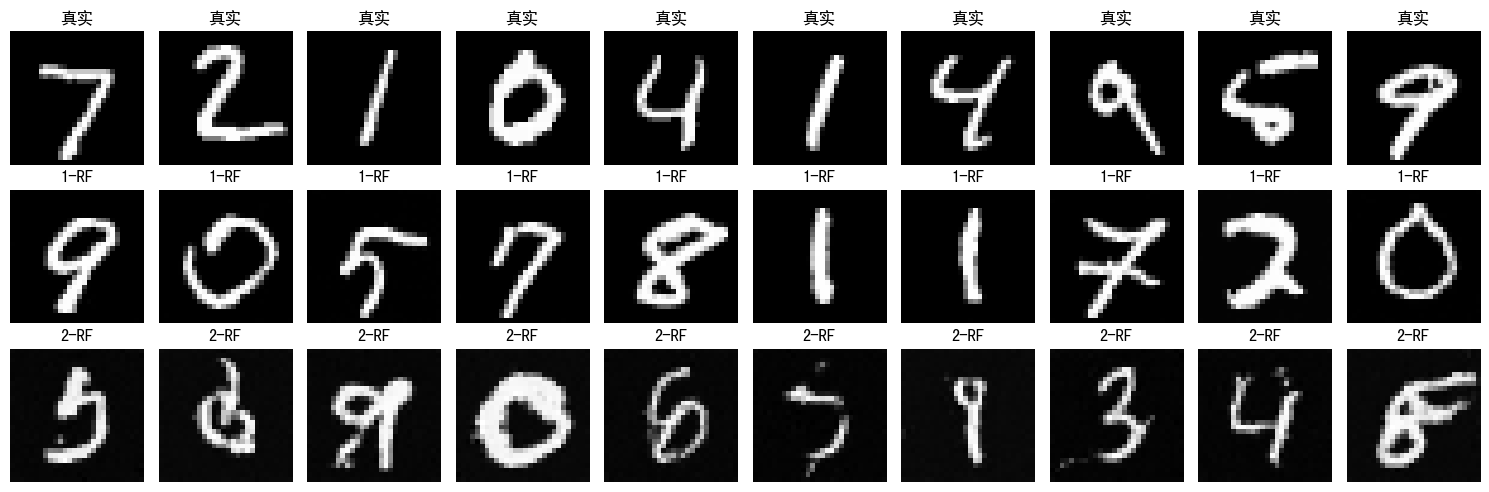

In [23]:
# 可视化生成结果
def visualize_results(generated_images_1rf, generated_images_2rf, real_images, num_samples=10):
    """可视化生成结果
    
    Args:
        generated_images_1rf: 1-Rectified Flow生成的图像
        generated_images_2rf: 2-Rectified Flow生成的图像
        real_images: 真实图像
        num_samples: 显示的样本数量
    """
    plt.figure(figsize=(15, 5))
    
    for i in range(num_samples):
        # 真实图像
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(real_images[i][0].numpy(), cmap='gray')
        plt.title('真实')
        plt.axis('off')
        
        # 1-Rectified Flow生成图像
        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(generated_images_1rf[i][0].numpy(), cmap='gray')
        plt.title('1-RF')
        plt.axis('off')
        
        # 2-Rectified Flow生成图像
        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(generated_images_2rf[i][0].numpy(), cmap='gray')
        plt.title('2-RF')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('./results/comparison.png', dpi=600)
    plt.show()

# 可视化结果对比
visualize_results(generated_images_1rf, generated_images_2rf, real_images, num_samples=10)